In [1]:
import numpy as np
import pandas as pd
import datetime
import xarray as xr
import os
import math

from pytz import timezone

import cartopy.crs as ccrs

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from metpy.units import units
import metpy.calc as mpcalc
from metpy.interpolate import cross_section

from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import scipy.io

import datetime

In [2]:
def nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def vertical_interpolate(vcoord_data, interp_var, interp_levels):
    
    # interpolate data to desired levels
    interp_data = np.interp(interp_levels, vcoord_data, interp_var)
    
    return interp_data

def radisonde_cross_section(times, all_data, start, end, step):

    # Set up vertical grid
    vertical_levels = np.arange(start, end, step)
    #vertical_levels[0] = 0

    # Number of vertical levels and times
    hlevs = len(vertical_levels)
    ntimes = len(times)

    # setting up needed variables
    elev = []
    xr_list = []
    keys = all_data.vars.values
    tmp_grid = dict.fromkeys(keys)
    
    # Interpolate all variables for each radiosonde observation
    # loop through each variable
    for key in tmp_grid.keys():
  
        # make empty grid to the size of the times by the height levels
        tmp_grid[key] = np.empty((ntimes, hlevs))
        
        # loop through times
        for time, loc in zip(times, range(ntimes)):

            # if the variable is height, then just save the desired height levels
            if key == 'HGHT':
                tmp_grid[key][loc, :] = vertical_levels
                
            # if it is any other variable, interpolate variable to desired height levels and store each 
            # variable together by time
            else:
                tmp_grid[key][loc, :] = vertical_interpolate(
                    all_data.sel(vars = 'HGHT', times = str(time)).values, all_data.sel(vars = key, times = str(time)).values,
                    vertical_levels)
            #print(tmp_grid[key][loc, :], '\n')
        
        # convert each interpolated variable by time into an xarray
        tmp_xr = xr.DataArray(tmp_grid[key], dims = ('time', 'height'), \
                              coords = {'time': times, 'height': vertical_levels})
        
        # add variable name as a coordinate
        tmp_xr = tmp_xr.assign_coords(coords={'vars': key})
        
        # append to list of xarrays
        xr_list.append(tmp_xr)

    # convert list of xarrays into an xarray  
    full_xr = xr.concat(xr_list, dim = 'vars')
    
    # make mesh for the time and height grid for each variable
    hght_grid, times_grid = np.meshgrid(vertical_levels, times)
            
    return full_xr, times_grid, hght_grid

In [3]:
def plot_radiosonde_profiles(time_grid, hght_grid, data, contour_low, contour_high, data_units, data_labels, \
                             data_name, colormap, c_step, quiv, time_skip, z_skip, U, V, end, outdir):
        
    # pull times into 1d array
    date_times = time_grid[0,:]
    
    # Start Figure, set big size for cross section
    fig = plt.figure(figsize=(11, 5))

    # Specify plotting axis (single panel)
    ax = plt.subplot(111)

    # Set y-scale to be log since pressure decreases exponentially with height
    #ax.set_yscale('log')

    # Set limits, tickmarks, and ticklabels for y-axis
    ax.set_ylim([end, -1])
    ax.set_yticks(range(end, -1, -2000))
    ax.set_yticklabels(range(end, -1, -2000))

    # Invert the y-axis since pressure decreases with increasing height
    ax.invert_yaxis()

    # Don't plot xticks
    plt.xticks()

    # Plot smooth contour filled data with black contour lines
    cf = ax.contourf(time_grid, hght_grid, data, range(contour_low, contour_high, 1), cmap = colormap)

    cs = ax.contour(time_grid, hght_grid, data, range(contour_low, contour_high, c_step), colors = 'k')

    cb = plt.colorbar(cf, orientation = 'vertical', shrink = 0.95, pad = 0.02, label = data_units)
    
    if (quiv == True):
        ax.quiver(time_grid[::time_skip,::z_skip], hght_grid[::time_skip,::z_skip],\
                  U[::time_skip,::z_skip], V[::time_skip,::z_skip], color = 'dimgray', pivot = 'middle')

    ax.clabel(cs, fmt='%i', colors = 'k')

    # Add some informative titles
    plt.ylabel('Height [m]')

    # make x laeled dates prettier
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y %H PDT'))
    fig.autofmt_xdate()

    plt.title(data_labels, loc = 'center')

    plot_name = data_name + '_profiler_time_profiles_' + str(date_times[0])[:-16].replace('-', '_').replace('T', '_') + \
                '_to_' + str(date_times[-1])[:-16].replace('-', '_').replace('T', '_') + '.png'
    
    plt.savefig(outdir+plot_name,  bbox_inches='tight', dpi = 120)
    plt.show()
    print('File saved as:', outdir+plot_name, '\n')
    

### opening wind profiler data and processing

In [4]:
# set datadir
datadir = '/home/sbarc/students/duine/oceanToValleyWind/data/obs/windProfiler/'

# set filenames
filenames = ['windProfiler_SBA_temps_20160824_20200924.mat', 'windProfiler_SBA_winds_20160824_20200924.mat']

# set output filepath
outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/'
fig_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/'
dat_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/data/'

In [5]:
# open temp and wind files
temp = scipy.io.loadmat(datadir + filenames[0])
wind = scipy.io.loadmat(datadir + filenames[1])

In [6]:
# convert from weird matlab time to normal
def return_datetime(matlab_datenum):
    return datetime.datetime.fromordinal(int(matlab_datenum)) + datetime.timedelta(days=matlab_datenum%1) - datetime.timedelta(days = 366)

temp_time_start = return_datetime(temp['tnumPST'][0,:][0])
temp_time_end = return_datetime(temp['tnumPST'][0,:][-1])

wind_time_start = return_datetime(wind['tnumPST'][0,:][0])
wind_time_end = return_datetime(wind['tnumPST'][0,:][-1])

In [7]:
# round start temp to nearest hour
temp_time_start = temp_time_start.replace(second=0, microsecond=0, minute=0, hour=temp_time_start.hour)+datetime.timedelta(hours=temp_time_start.minute//30)

In [8]:
# make pandas datetime for temps
temp_time = pd.date_range(start = temp_time_start, end = temp_time_end + datetime.timedelta(hours = 1), freq='60min')

In [9]:
# make pandas datetime for winds
wind_time = pd.date_range(start = wind_time_start, end = wind_time_end + datetime.timedelta(hours = 1), freq='60min')

In [10]:
# turn temp data into xarray dataset
temp_ds = xr.Dataset({'tempC': (['height','time'], temp['tempC']),
                      'w': (['height','time'], temp['vertW'])},
                      coords = {'time': temp_time, 'height': temp['height'][:,100]})

In [11]:
# turn wind data into xarray dataset
wind_ds = xr.Dataset({'wspd': (['height','time'], wind['wspd2']),
                      'wdir': (['height','time'], wind['wdir2']),
                      'u': (['height','time'], wind['u2']),
                      'v': (['height','time'], wind['v2']),},
                      coords = {'time': wind_time, 'height': wind['height2'][:,0]})

In [12]:
wind_ds = wind_ds.sel(time = slice('2017-05-21T17:00:00.000000000', '2017-05-25T05:00:00.000000000'))

In [13]:
temp_ds = temp_ds.sel(time = slice('2017-05-21T17:00:00.000000000', '2017-05-25T05:00:00.000000000'))

In [14]:
# mesh up time and heights for plotting
temp_times_grid, temp_hght_grid = np.meshgrid(temp_ds.time.values, temp_ds.height.values)

# mesh up time and heights for plotting
wind_times_grid, wind_hght_grid = np.meshgrid(wind_ds.time.values, wind_ds.height.values)

### opening wrfout files and processing

In [15]:
station_lats = [34.42611]
station_lons = [-119.84361] 
stations = ["KSBA"]

# Set filepath
datadir = '../input_data/wrf_out_post/'

# set file names
filename = ['wrfout_d03_2017-05-22_00:00:00_zlev', 'wrfout_d03_2017-05-23_00:00:00_zlev', 
            'wrfout_d03_2017-05-24_00:00:00_zlev', 'wrfout_d03_2017-05-25_00:00:00_zlev']   

da_list = []
dates_list = []


for j in range(len(filename)):

    # open wrf Dataset object
    filepath = datadir + filename[j]
    dat = xr.open_dataset(filepath)
    print('Opened File:', filepath)

    # append xarray to a list
    da_list.append(dat)

# convert list of xarrays to one xarray
ds = xr.concat(da_list, dim = 'time')

# limit wrf data time frame by station datae
ds = ds.sel(time = slice(str(ds.time.values[0]), str(ds.time.values[-1])))

da_list = []

# adjust station lats and lons to have the nearest wrf lat and lon to station location
for i in range(len(stations)):
    
    # interpoalte to specific station location
    ds_tmp = ds.interp(lat = station_lats[i], lon = station_lons[i])
    
    # add station name as coordinate
    ds_tmp = ds_tmp.assign_coords(station = stations[i])
    
    # append xarray to a list
    da_list.append(ds_tmp)
    
# convert list of xarrays to one xarray
dwrf = xr.concat(da_list, dim = 'station')

Opened File: ../input_data/wrf_out_post/wrfout_d03_2017-05-22_00:00:00_zlev
Opened File: ../input_data/wrf_out_post/wrfout_d03_2017-05-23_00:00:00_zlev
Opened File: ../input_data/wrf_out_post/wrfout_d03_2017-05-24_00:00:00_zlev
Opened File: ../input_data/wrf_out_post/wrfout_d03_2017-05-25_00:00:00_zlev


In [16]:
# mesh up time and heights for plotting
hght_grid_wrf, times_grid_wrf = np.meshgrid(dwrf.z.values, dwrf.time.values)

In [17]:
# convert temp to C
dwrf['tempC'] = dwrf['temp'] - 273.15

### plottting

In [18]:
ymax = 7000

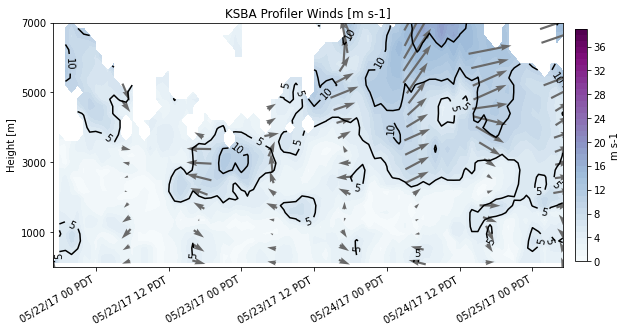

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/wspd_KSBA_profiler_time_profiles_2017_05_21_17_to_2017_05_25_05.png 



In [19]:
wnd_min = 0
wnd_max = 40

plot_radiosonde_profiles(wind_times_grid, wind_hght_grid, wind_ds['wspd'], wnd_min, wnd_max, 'm s-1', \
                         'KSBA Profiler Winds [m s-1]', 'wspd_KSBA',\
                         'BuPu', 5, True, 2, 12, wind_ds['u'], wind_ds['v'], ymax, fig_outdir)

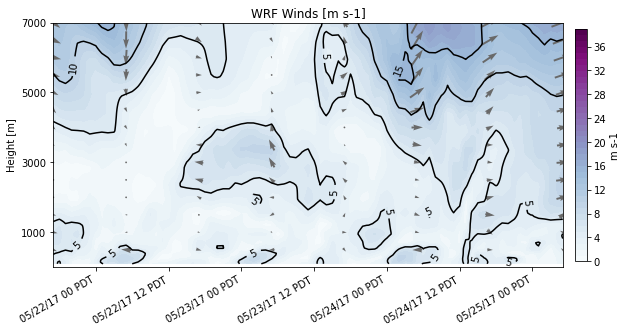

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/wind_wrf_profiler_time_profiles_2017_05_21_17_to_2017_05_21_17.png 



In [20]:
plot_radiosonde_profiles(times_grid_wrf, hght_grid_wrf, dwrf['wspd'].sel(station = "KSBA"), \
                         wnd_min, wnd_max, 'm s-1', 'WRF Winds [m s-1]', 'wind_wrf', 'BuPu', \
                         5, True, 12, 10, dwrf['u'].sel(station = "KSBA"), \
                         dwrf['v'].sel(station = "KSBA"), ymax, fig_outdir)

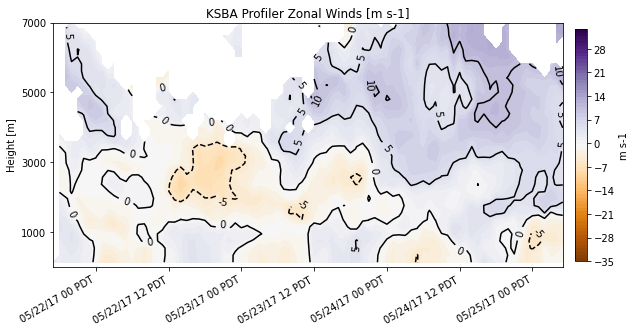

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/U_wind_KSBA_profiler_time_profiles_2017_05_21_17_to_2017_05_25_05.png 



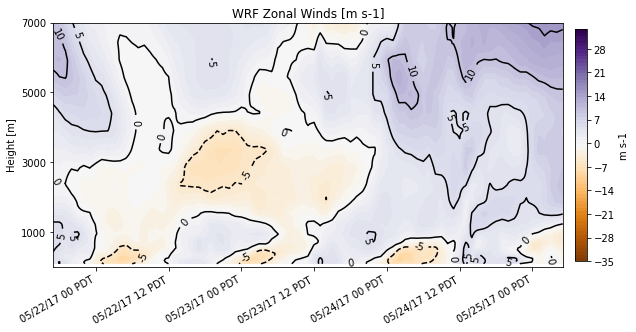

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/U_wind_wrf_profiler_time_profiles_2017_05_21_17_to_2017_05_21_17.png 



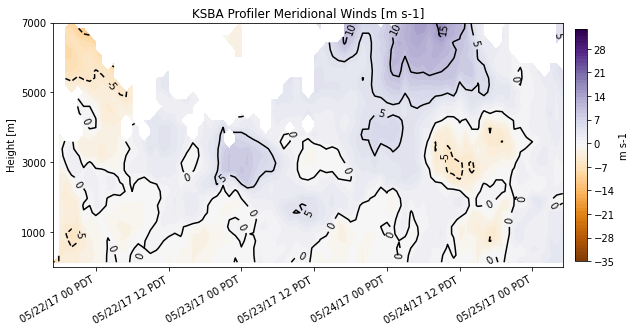

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/V_wind_KSBA_profiler_time_profiles_2017_05_21_17_to_2017_05_25_05.png 



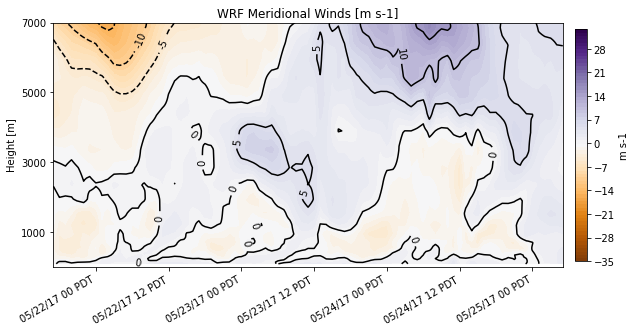

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/V_wind_wrf_profiler_time_profiles_2017_05_21_17_to_2017_05_21_17.png 



In [21]:
uv_min = -35
uv_max = 35

plot_radiosonde_profiles(wind_times_grid, wind_hght_grid, wind_ds['u'], uv_min, uv_max, 'm s-1', \
                         'KSBA Profiler Zonal Winds [m s-1]', 'U_wind_KSBA', 'PuOr', \
                         5, False, None, None, None, None, ymax, fig_outdir)

plot_radiosonde_profiles(times_grid_wrf, hght_grid_wrf, dwrf['u'].sel(station = "KSBA"),\
                         uv_min, uv_max, 'm s-1', 'WRF Zonal Winds [m s-1]', 'U_wind_wrf', 'PuOr', \
                         5, False, None, None, None, None, ymax, fig_outdir)

plot_radiosonde_profiles(wind_times_grid, wind_hght_grid, wind_ds['v'], uv_min, uv_max, 'm s-1', \
                         'KSBA Profiler Meridional Winds [m s-1]', 'V_wind_KSBA', 'PuOr', \
                         5, False, None, None, None, None, ymax, fig_outdir)

plot_radiosonde_profiles(times_grid_wrf, hght_grid_wrf, dwrf['v'].sel(station = "KSBA"), \
                         uv_min, uv_max, 'm s-1', 'WRF Meridional Winds [m s-1]', 'V_wind_wrf', 'PuOr', \
                         5, False, None, None, None, None, ymax, fig_outdir)

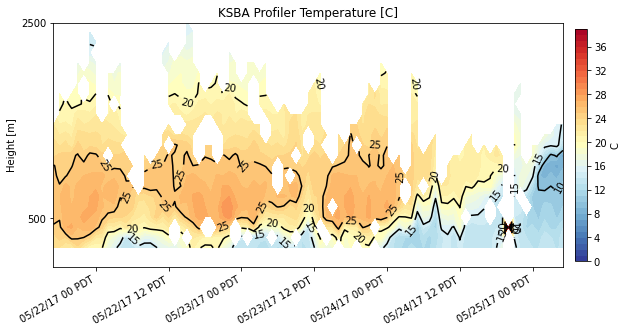

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/temp_KSBA_profiler_time_profiles_2017_05_21_17_to_2017_05_25_05.png 



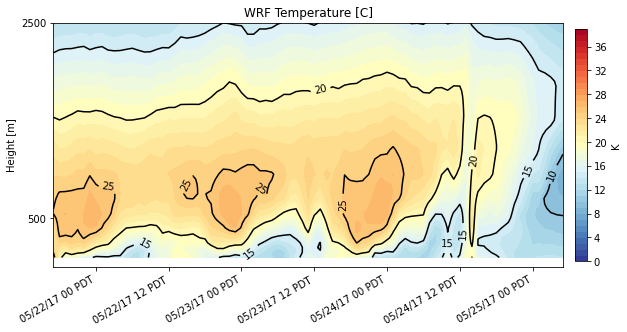

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/temp_wrf_profiler_time_profiles_2017_05_21_17_to_2017_05_21_17.png 



In [22]:
plot_radiosonde_profiles(temp_times_grid, temp_hght_grid, temp_ds['tempC'], 0, 40, 'C',\
                         'KSBA Profiler Temperature [C]', 'temp_KSBA', 'RdYlBu_r', \
                         5, False, None, None, None, None, 2500, fig_outdir)


plot_radiosonde_profiles(times_grid_wrf, hght_grid_wrf, dwrf['tempC'].sel(station = "KSBA"),\
                         0, 40, 'K', 'WRF Temperature [C]', 'temp_wrf', 'RdYlBu_r', \
                         5, False, None, None, None, None, 2500, fig_outdir)